In [ ]:
# ==========================================
# 1. 라이브러리 임포트
# ==========================================
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, concatenate,
    LSTM, Dense, Dropout
)


In [ ]:
# ==========================================
# 2. 파일 읽기 함수
# ==========================================
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

def load_group(filenames, prefix=''):
    loaded = []
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    return np.dstack(loaded)

def load_dataset_group(group, base_path):
    signal_path = f"{base_path}/{group}/Inertial Signals/"

    filenames = [
        'total_acc_x_', 'total_acc_y_', 'total_acc_z_',
        'body_acc_x_',  'body_acc_y_',  'body_acc_z_',
        'body_gyro_x_', 'body_gyro_y_', 'body_gyro_z_'
    ]

    filenames = [f"{name}{group}.txt" for name in filenames]

    X = load_group(filenames, signal_path)
    y = load_file(f"{base_path}/{group}/y_{group}.txt")
    return X, y


In [ ]:
# ==========================================
# 3. 전체 데이터셋 로딩
# ==========================================
def load_dataset():
    base_path = "/content/drive/MyDrive/Colab Notebooks/UCI HAR Dataset"

    X_train, y_train = load_dataset_group("train", base_path)
    X_test, y_test = load_dataset_group("test", base_path)

    y_train -= 1
    y_test -= 1

    y_train_onehot = to_categorical(y_train)
    y_test_onehot = to_categorical(y_test)

    print("Loaded shapes:")
    print("X_train:", X_train.shape)
    print("y_train:", y_train_onehot.shape)
    print("X_test:", X_test.shape)
    print("y_test:", y_test_onehot.shape)

    return X_train, y_train_onehot, X_test, y_test_onehot

In [ ]:
# ==========================================
# 4. 데이터 불러오기
# ==========================================
X_train, y_train_onehot, X_test, y_test_onehot = load_dataset()

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train_onehot, test_size=0.2, random_state=100
)

print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)

/tmp/ipython-input-860885397.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-860885397.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-860885397.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-860885397.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp

Loaded shapes:
X_train: (7352, 128, 9)
y_train: (7352, 6)
X_test: (2947, 128, 9)
y_test: (2947, 6)
Train: (5881, 128, 9)
Val: (1471, 128, 9)
Test: (2947, 128, 9)


In [ ]:
# ==========================================
# 5. 입력 차원 정의
# ==========================================
n_timesteps, n_features = X_train.shape[1], X_train.shape[2]
n_outputs = y_train.shape[1]

print("Timesteps:", n_timesteps)
print("Features:", n_features)
print("Outputs:", n_outputs)

Timesteps: 128
Features: 9
Outputs: 6


In [ ]:
# ==========================================
# 6. CNN + LSTM 모델 정의
# ==========================================
inputs = Input(shape=(n_timesteps, n_features))

# Level 1
c1 = Conv1D(128, 3, activation='relu', padding='same')(inputs)
c2 = Conv1D(128, 5, activation='relu', padding='same')(inputs)
c3 = Conv1D(128, 7, activation='relu', padding='same')(inputs)
c4 = Conv1D(128, 9, activation='relu', padding='same')(inputs)

m1 = concatenate([c1, c2, c3, c4], axis=-1)
p1 = MaxPooling1D(pool_size=2)(m1)

# Level 2
c5 = Conv1D(64, 3, activation='relu', padding='same')(p1)
c6 = Conv1D(64, 5, activation='relu', padding='same')(p1)
c7 = Conv1D(64, 7, activation='relu', padding='same')(p1)
c8 = Conv1D(64, 9, activation='relu', padding='same')(p1)

m2 = concatenate([c5, c6, c7, c8], axis=-1)
p2 = MaxPooling1D(pool_size=2)(m2)

# Level 3
c9  = Conv1D(32, 3, activation='relu', padding='same')(p2)
c10 = Conv1D(32, 5, activation='relu', padding='same')(p2)
c11 = Conv1D(32, 7, activation='relu', padding='same')(p2)
c12 = Conv1D(32, 9, activation='relu', padding='same')(p2)

m3 = concatenate([c9, c10, c11, c12], axis=-1)
p3 = MaxPooling1D(pool_size=2)(m3)

In [ ]:
# LSTM
lstm_out = LSTM(128)(p3)

# Dense
dense = Dense(256, activation='relu')(lstm_out)
dense = Dropout(0.5)(dense)
outputs = Dense(n_outputs, activation='softmax')(dense)

# 모델 구성
model = Model(inputs, outputs)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 128, 128)  │      3,584 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 128, 128)  │      5,888 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 128, 128)  │      8,192 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 128, 128)  │     10,496 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 512)  │          0 │ conv1d[0][0],     │
│ (Concatenate)       │                   │            │ conv1d_1[0][0],   │
│                     │                   │            │ conv1d_2[0][0],   │
│                     │                   │            │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 64, 512)   │          0 │ concatenate[0][0] │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 64, 64)    │     98,368 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 64, 64)    │    163,904 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 64, 64)    │    229,440 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 64, 64)    │    294,976 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 64, 256)   │          0 │ conv1d_4[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_5[0][0],   │
│                     │                   │            │ conv1d_6[0][0],   │
│                     │                   │            │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 32, 256)   │          0 │ concatenate_1[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 32, 32)    │     24,608 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 32, 32)    │     40,992 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 32, 32)    │     57,376 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 32, 32)    │     73,760 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 32, 128)   │          0 │ conv1d_8[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_9[0][0],   │
│                     │                   │            │ conv1d_10[0][0],  │
│                     │                   │            │ conv1d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 16, 128)   │          0 │ concatenate_2[0]

 Total params: 1,177,734 (4.49 MB)

 Trainable params: 1,177,734 (4.49 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ==========================================
# 7. 모델 학습
# ==========================================
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val)
)

Epoch 1/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.6295 - loss: 0.8339 - val_accuracy: 0.8464 - val_loss: 0.3902
Epoch 2/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9346 - loss: 0.1803 - val_accuracy: 0.9436 - val_loss: 0.1301
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9517 - loss: 0.1201 - val_accuracy: 0.9477 - val_loss: 0.1209
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9465 - loss: 0.1241 - val_accuracy: 0.9456 - val_loss: 0.1457
Epoch 5/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9477 - loss: 0.1247 - val_accuracy: 0.9443 - val_loss: 0.1199
Epoch 6/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9524 - loss: 0.1173 - val_accuracy: 0.9545 - val_loss: 0.1049
Epoch 7/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9569 - loss: 0.0974 - val_accuracy: 0.9524 - val_loss: 0.1101
Epoch 8/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9641 - loss: 0.0949 - val_acc

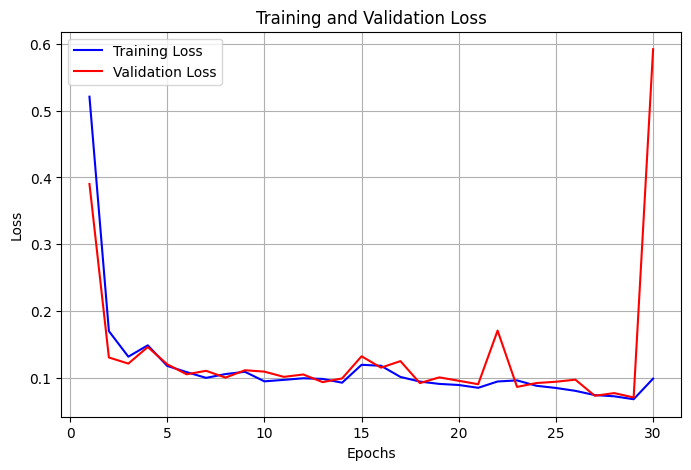

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np

# ====================================
# 1. Training / Validation Loss Plot
# ====================================
plt.figure(figsize=(8, 5))
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


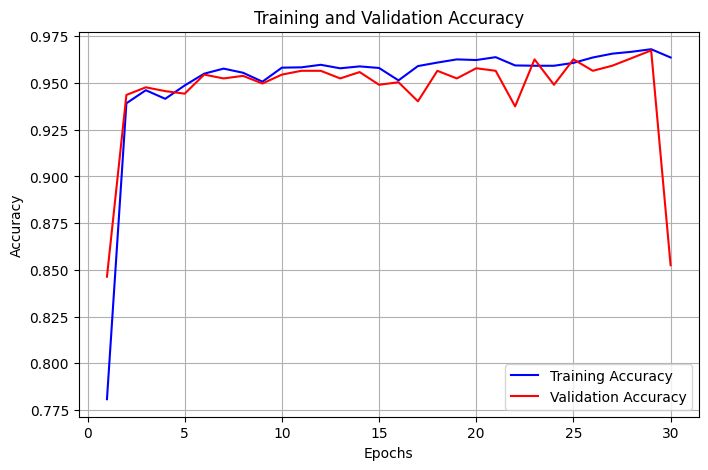

In [ ]:
# ====================================
# 2. Training / Validation Accuracy Plot
# ====================================
plt.figure(figsize=(8, 5))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
Test Accuracy : 0.7726501526976587

Classification Report:

              precision    recall  f1-score   support

           0     0.9973    0.7460    0.8535       496
           1     0.8054    0.2548    0.3871       471
           2     0.4895    1.0000    0.6573       420
           3     0.8409    0.7210    0.7763       491
           4     0.7884    0.9455    0.8598       532
           5     1.0000    0.9497    0.9742       537

    accuracy                         0.7727      2947
   macro avg     0.8202    0.7695    0.7514      2947
weighted avg     0.8310    0.7727    0.7613      2947



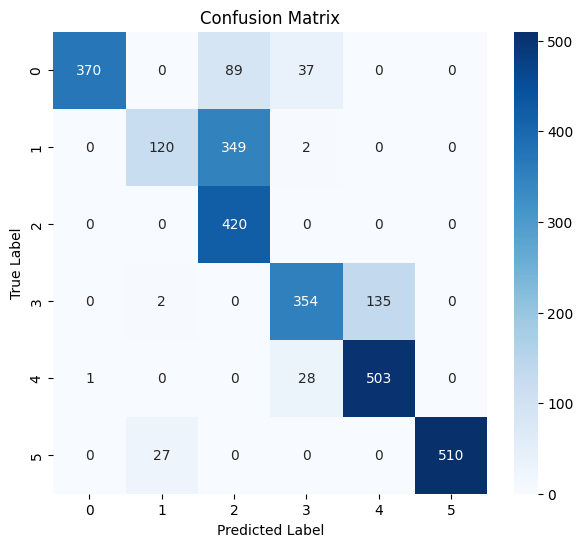

In [ ]:
# ====================================
# 3. Confusion Matrix & Report
# ====================================

# CNN+LSTM 모델은 X_test 하나만 넣으면 됨!
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)

y_true = np.argmax(y_test_onehot, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, pred)

print("Test Accuracy :", accuracy_score(y_true, pred))
print("\nClassification Report:\n")
print(classification_report(y_true, pred, digits=4))

# Heatmap
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()